In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt

In [403]:
def elbo(recon_x, x, mu, log_var,):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # Outputs both mean and log variance
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output range [0, 1]
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)  # Split the result into mean and log variance
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

    def fit(self, X, lr=0.1, optimizer='Adam', epochs=20, batch_size=128, loss='elbo', shuffle=True):
        optimizer = getattr(optim, optimizer)(self.parameters(), lr=lr)
    
        try:
            loss_fn = getattr(nn, loss)()
        except:
            loss_fn = elbo
    
        mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle)
    
        for epoch in range(1, epochs+1):
            train_loss = 0.0
            batch_num = 0
    
            for data in mnist_trainset:
                images, _ = data
                images = images.view(images.size(0), -1)
    
                optimizer.zero_grad()
                y_hat, mu, log_var = self(images)
    
                loss = loss_fn(y_hat, images, mu, log_var,)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()
    
                print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {loss.item()/len(images):.6f}', end='\r')
                batch_num += images.size(0)
    
            train_loss = train_loss / len(X.data)
            print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {train_loss:.6f}')

In [404]:
vae = VAE(28*28, 400, 2)
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [405]:
# Trainset
transform = transforms.ToTensor()
mnist_train = datasets.MNIST('data/', download=True, train=True, transform=transform)

# Testset
mnist_test = datasets.MNIST('data/', download=True, train=False, transform=transform)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [406]:
# dataloader
num_workers = 0
batch_size = 128

mnist_trainset = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers)
mnist_testset = DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers)

In [407]:
images, labels = next(iter(mnist_trainset))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [408]:
def plot_images(images, labels, num_images=10, col=2):
    idx = np.random.choice(len(images), num_images, replace=False)
    imgs = images[idx]
    lbs = labels[idx]
    

    row = int(np.ceil(num_images/col))
    col = col
    fig, axes = plt.subplots(row, col)
    
    for i in range(row):
        for j in range(col):
            if i*col+j < len(imgs):
                axes[i, j].imshow(np.squeeze(imgs[i*col+j]), cmap='gray')
                axes[i, j].set_title(f'{lbs[i*col+j].item()}')

    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.show()

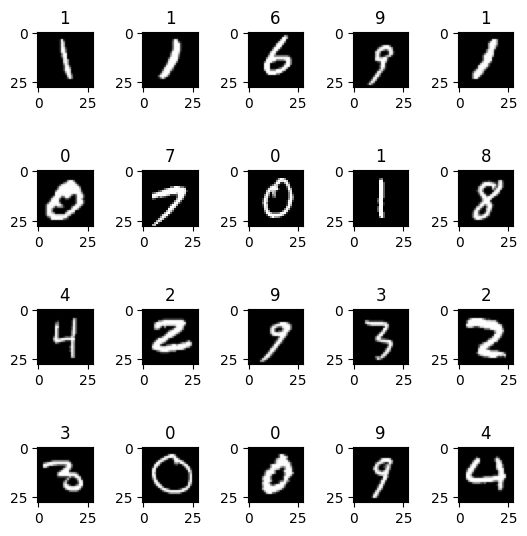

In [409]:
n_num = 20
plot_images(images, labels, num_images=n_num, col=5)

In [410]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [411]:
vae = VAE(28*28, 400, 2)
#vae.apply(init_weights)
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [412]:
vae.fit(mnist_train, epochs=20, lr=0.001, batch_size=128, optimizer='Adam', loss='elbo')

Epoch: 1 [60000/60000], Loss: 189.720940
Epoch: 2 [60000/60000], Loss: 167.466573
Epoch: 3 [60000/60000], Loss: 163.017363
Epoch: 4 [60000/60000], Loss: 160.608253
Epoch: 5 [60000/60000], Loss: 158.899392
Epoch: 6 [60000/60000], Loss: 157.569499
Epoch: 7 [60000/60000], Loss: 156.557213
Epoch: 8 [60000/60000], Loss: 155.664474
Epoch: 9 [60000/60000], Loss: 154.864800
Epoch: 10 [60000/60000], Loss: 154.214359
Epoch: 11 [60000/60000], Loss: 153.571079
Epoch: 12 [60000/60000], Loss: 153.068037
Epoch: 13 [60000/60000], Loss: 152.589292
Epoch: 14 [60000/60000], Loss: 152.097258
Epoch: 15 [60000/60000], Loss: 151.703361
Epoch: 16 [60000/60000], Loss: 151.354910
Epoch: 17 [60000/60000], Loss: 151.026110
Epoch: 18 [60000/60000], Loss: 150.660972
Epoch: 19 [60000/60000], Loss: 150.372503
Epoch: 20 [60000/60000], Loss: 150.110792


In [413]:
def plot_generated_images(images, reimages, labels, num_images=10):
    idx = np.random.choice(len(images), num_images, replace=False)
    imgs = images[idx]
    reimgs = reimages[idx]
    lbs = labels[idx]

    row = num_images
    fig, axes = plt.subplots(row, 2)
    
    for i in range(row):
        for j in range(2):
            if j == 0:
                axes[i, j].imshow(imgs[i].reshape(28, 28).detach().numpy(), cmap='gray')
                axes[i, j].set_title(f'{lbs[i].item()}')
                continue
            axes[i, j].imshow(reimgs[i].reshape(28, 28).detach().numpy(), cmap='gray')
            axes[i, j].set_title(f'{lbs[i].item()}')

    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.show()

torch.Size([10000, 784])


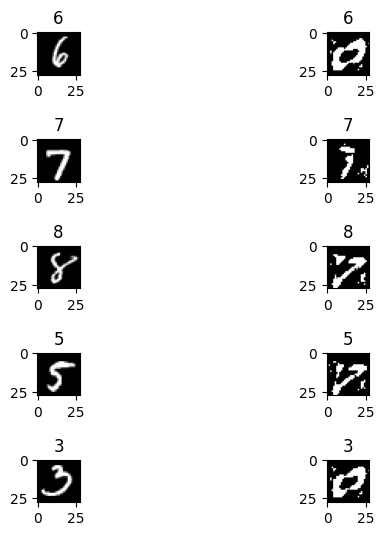

In [453]:
recon_images, _, _ = vae(mnist_test.data.view(-1, 28*28).type(torch.FloatTensor))
print(recon_images.shape)
plot_generated_images(mnist_test.data.view(-1, 28*28), recon_images.view(-1, 28*28), mnist_test.targets, num_images=5)

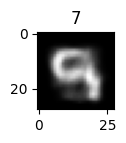

In [461]:
z = torch.rand(1, 2)
recon = vae.decode(z)
plt.figure(figsize=(1,1))
plt.imshow(recon.reshape(28,28).detach().numpy(), cmap='gray')
plt.title(mnist_test.targets[0].item())
plt.show()

In [445]:
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes, hidden_layers=[512, 256]):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential()

        for i in range(len(hidden_layers)):
            if i == 0:
                self.encoder.append(nn.Linear(input_dim+num_classes, hidden_layers[i]))
                self.encoder.append(nn.ReLU())
                continue
            self.encoder.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.encoder.append(nn.ReLU())
        
        # encoder output
        self.encoder.append(nn.Linear(hidden_layers[-1], latent_dim))
        #self.encoder.append(nn.Sigmoid())
        
        # Decoder
        hidden_layers.reverse()
        self.decoder = nn.Sequential()

        for i in range(len(hidden_layers)):
            if i == 0:
                self.decoder.append(nn.Linear(latent_dim + num_classes, hidden_layers[i]))
                self.decoder.append(nn.ReLU())
                continue
            self.decoder.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.decoder.append(nn.ReLU())

        # decoder output
        self.decoder.append(nn.Linear(hidden_layers[-1], input_dim))
        self.decoder.append(nn.Sigmoid())
        
    
    def encode(self, x, c):
        h = torch.cat([x, c], dim=1)
        h = self.encoder(h)
        mu, log_var = h, h  # Split the result into mean and log variance
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decode(self, z, c):
        h = torch.cat([z, c], dim=1)
        return self.decoder(h)
    
    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var

    def elbo(self, recon_x, x, mu, log_var):
        BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD

    def fit(self, X, lr=0.1, optimizer='Adam', epochs=20, batch_size=128, loss='elbo', shuffle=False, num_workders=0):
        optimizer = getattr(optim, optimizer)(self.parameters(), lr=lr)
        
        try:
            loss_fn = getattr(nn, loss)()
        except:
            loss_fn = getattr(self, 'elbo')
    
        mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
        for epoch in range(1, epochs+1):
            train_loss = 0
            batch_num = 0
    
            for data in mnist_trainset:
                images, labels = data
                c = torch.eye(10)[labels]
    
                optimizer.zero_grad()
                images = images.view(images.size(0), -1)

                y_hat, mu, log_var = self.forward(images, c)
                loss = loss_fn(y_hat, images, mu, log_var)
                loss.backward()
                optimizer.step()
    
                print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {loss.item()/len(images):.6f}', end='\r')
                train_loss += loss.item()
                batch_num += images.size(0)
                
            train_loss = train_loss / len(X.data)
            print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {train_loss:.6f}')

In [446]:
cvae = CVAE(28*28, 2, 10, hidden_layers=[400])
cvae

CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [473]:
cvae.fit(mnist_train, epochs=15, lr=0.001, batch_size=20, optimizer='Adam', loss='elbo')

Epoch: 1 [60000/60000], Loss: 142.440211
Epoch: 2 [60000/60000], Loss: 142.397545
Epoch: 3 [60000/60000], Loss: 142.231069
Epoch: 4 [60000/60000], Loss: 142.111079
Epoch: 5 [60000/60000], Loss: 142.010801
Epoch: 6 [60000/60000], Loss: 141.901144
Epoch: 7 [60000/60000], Loss: 141.796405
Epoch: 8 [60000/60000], Loss: 141.852455
Epoch: 9 [60000/60000], Loss: 141.767379
Epoch: 10 [60000/60000], Loss: 141.647287
Epoch: 11 [60000/60000], Loss: 141.663336
Epoch: 12 [60000/60000], Loss: 141.573600
Epoch: 13 [60000/60000], Loss: 141.520300
Epoch: 14 [60000/60000], Loss: 141.397467
Epoch: 15 [60000/60000], Loss: 141.458367


In [474]:
images, labels = mnist_test.data, mnist_test.targets
c = torch.eye(10)[labels]

images.shape, c.shape

(torch.Size([10000, 28, 28]), torch.Size([10000, 10]))

In [475]:
recon_images, _, _ = cvae(images.view(-1, 28*28), c)

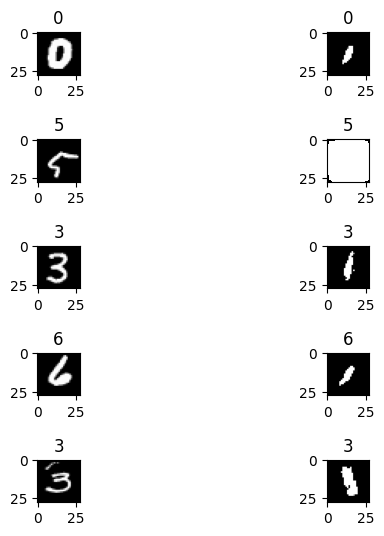

In [476]:
plot_generated_images(mnist_test.data.view(-1, 28*28), recon_images, mnist_test.targets, num_images=5)

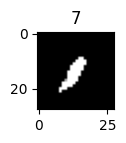

In [479]:
plt.figure(figsize=(1,1))
plt.title(mnist_test.targets[0].item())
plt.imshow(recon_images[0].view(28, 28).detach().numpy(), cmap='gray')